In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../src/")
import importlib
import structures
importlib.reload(structures)
from structures import *
#import losses
#importlib.reload(losses)
#from losses import *
#import trainer
#importlib.reload(trainer)
#from trainer import *
#dtype = torch.float32
#dtype = torch.double
dtype = torch.float32
torch.set_default_dtype(dtype)
torch.autograd.set_detect_anomaly(True)
# Set the device to CUDA if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#import deepspeed
import random
sys.path.append("/mnt/home/yjo10/ceph/myutils")
import plt_utils as pu

torch.cuda.empty_cache()
import gc
# Garbage collect
gc.collect()
# Cosine‑annealing with warmup
#from timm.scheduler import create_scheduler
from types import SimpleNamespace
from tqdm import tqdm


Using device: cuda


In [2]:
sys.path.append("../src/")
import importlib
import dataloader
importlib.reload(dataloader)
from dataloader import *
torch.cuda.empty_cache()
import gc
# Garbage collect
gc.collect()

29

In [54]:
individual = False
_dataSB28, _labelsSB28, _minmaxSB28 = loadCAMELS(field="Mtot",box="SB28", normalization=False, individual=individual)
_dataSB35, _labelsSB35, _minmaxSB35 = loadCAMELS(field="Mtot",box="SB35", normalization=False, individual=individual)
#labelsSB28 = torch.tensor(_labelsSB28[:,:2], dtype=dtype)
#labelsSB35 = torch.tensor(_labelsSB35[:,:2], dtype=dtype)
labelsSB28 = torch.tensor(_labelsSB28[:,[0,1,6,7,8]], dtype=dtype)
labelsSB35 = torch.tensor(_labelsSB35[:,[0,1,6,7,8]], dtype=dtype)


monopole_analysis = True
if monopole_analysis:
  dataSB35_cutout = _dataSB35[:,:256,:256]
  monopole28        = _dataSB28.mean(axis=(1,2))
  monopole35_cutout = dataSB35_cutout.mean(axis=(1,2))
  monopole35        = _dataSB35.mean(axis=(1,2))
  #_labelsSB28[:,2] = monopole28
  #_labelsSB35[:,2] = monopole35_cutout
  labelsSB28 = torch.tensor(_labelsSB28[:,[0,1,6,7,8]], dtype=dtype)
  labelsSB35 = torch.tensor(_labelsSB35[:,[0,1,6,7,8]], dtype=dtype)
else:
  labelsSB28 = torch.tensor(_labelsSB28[:,[0,1,6,7,8]], dtype=dtype)
  labelsSB35 = torch.tensor(_labelsSB35[:,[0,1,6,7,8]], dtype=dtype)


In [55]:
batch_size = 64
linear = False
#dataSB28_norm = np.log10(_dataSB28[:,:224,:224])
dataSB28_norm = np.log10(_dataSB28)
if linear:
  dataSB28_norm_max, dataSB28_norm_min = dataSB28_norm.max(), dataSB28_norm.min()
  dataSB28_norm = (dataSB28_norm -  dataSB28_norm_min)/(dataSB28_norm_max-dataSB28_norm_min)
else:
  if individual:
    dataSB28_norm_mean, dataSB28_norm_std =\
      dataSB28_norm.mean(axis=(1, 2), keepdims=True), dataSB28_norm.std(axis=(1, 2), keepdims=True)
  else:
    dataSB28_norm_mean, dataSB28_norm_std = dataSB28_norm.mean(), dataSB28_norm.std()
  dataSB28_norm = (dataSB28_norm -  dataSB28_norm_mean)/dataSB28_norm_std

cutout = False
if cutout:
  dataSB35_cutout = np.r_[_dataSB35[:,:256,:256],_dataSB35[:,:256,256:]]
  dataSB35_cutout = np.r_[dataSB35_cutout,_dataSB35[:,256:,:256]]
  dataSB35_cutout = np.r_[dataSB35_cutout,_dataSB35[:,256:,256:]]
  dataSB35_cutout_norm = np.log10(dataSB35_cutout)
  #dataSB35_cutout_norm = np.log10(_dataSB35_cutout[:,:256,:256])
  if linear:
    dataSB35_cutout_norm = (dataSB35_cutout_norm -  dataSB28_norm_min)/(dataSB28_norm_max-dataSB28_norm_min)
  else:
    if individual:
      dataSB35_cutout_norm_mean, dataSB35_cutout_norm_std =\
        dataSB35_cutout_norm.mean(axis=(1, 2), keepdims=True), dataSB35_cutout_norm.std(axis=(1, 2), keepdims=True)
      dataSB35_cutout_norm = (dataSB35_cutout_norm -  dataSB35_cutout_norm_mean)/dataSB35_cutout_norm_std
    else:
      dataSB35_cutout_norm = (dataSB35_cutout_norm -  dataSB28_norm_mean)/dataSB28_norm_std

  dataSB35_cutout = torch.tensor(dataSB35_cutout_norm,dtype=dtype)
  _, val_setSB35_cutout = split_expanded_dataset(dataSB35_cutout, labelsSB35, chunk_size=30, val_ratio=0.2,shuffle=True)
  val_loaderSB35_cutout = DataLoader(val_setSB35_cutout, batch_size=batch_size, shuffle=False)


dataSB35_norm = np.log10(_dataSB35)
#dataSB35_norm = np.log10(_dataSB35[:,:256,:256])
if linear:
  dataSB35_norm_max, dataSB35_norm_min = dataSB35_norm.max(), dataSB35_norm.min()
  dataSB35_norm = (dataSB35_norm -  dataSB35_norm_min)/(dataSB35_norm_max-dataSB35_norm_min)
else:
  if individual:
    dataSB35_norm_mean, dataSB35_norm_std =\
      dataSB35_norm.mean(axis=(1, 2), keepdims=True), dataSB35_norm.std(axis=(1, 2), keepdims=True)
  else:
    dataSB35_norm_mean, dataSB35_norm_std = dataSB35_norm.mean(), dataSB35_norm.std()
  dataSB35_norm = (dataSB35_norm -  dataSB35_norm_mean)/dataSB35_norm_std


dataSB28 = torch.tensor(dataSB28_norm,dtype=dtype)
_, val_setSB28 = split_expanded_dataset(dataSB28, labelsSB28, chunk_size=15, val_ratio=0.2, shuffle=True)
val_loaderSB28 = DataLoader(val_setSB28, batch_size=batch_size, shuffle=False)

dataSB35 = torch.tensor(dataSB35_norm,dtype=dtype)
_, val_setSB35 = split_expanded_dataset(dataSB35, labelsSB35, chunk_size=30, val_ratio=0.2,shuffle=True)
val_loaderSB35 = DataLoader(val_setSB35, batch_size=batch_size, shuffle=False)

In [4]:
linear = False
batch_size=32

dataSB28_norm = np.log10(_dataSB28)
if linear:
  dataSB28_norm_max, dataSB28_norm_min = dataSB28_norm.max(), dataSB28_norm.min()
  dataSB28_norm = (dataSB28_norm -  dataSB28_norm_min)/(dataSB28_norm_max-dataSB28_norm_min)
else:
  if individual:
    dataSB28_norm_mean, dataSB28_norm_std =\
      dataSB28_norm.mean(axis=(1, 2), keepdims=True), dataSB28_norm.std(axis=(1, 2), keepdims=True)
  else:
    dataSB28_norm_mean, dataSB28_norm_std = dataSB28_norm.mean(), dataSB28_norm.std()
  dataSB28_norm = (dataSB28_norm -  dataSB28_norm_mean)/dataSB28_norm_std


#dataSB35_cutout = np.r_[_dataSB35[:,:256,:256],_dataSB35[:,:256,256:]]
#dataSB35_cutout = np.r_[dataSB35_cutout,_dataSB35[:,256:,:256]]
#dataSB35_cutout = np.r_[dataSB35_cutout,_dataSB35[:,256:,256:]]
dataSB35_cutout = _dataSB35[:,:256,:256]
dataSB35_cutout_norm = np.log10(dataSB35_cutout)
#dataSB35_cutout_norm = np.log10(_dataSB35_cutout[:,:256,:256])
if linear:
  dataSB35_cutout_norm = (dataSB35_cutout_norm -  dataSB28_norm_min)/(dataSB28_norm_max-dataSB28_norm_min)
else:
  if individual:
    dataSB35_cutout_norm_mean, dataSB35_cutout_norm_std =\
      dataSB35_cutout_norm.mean(axis=(1, 2), keepdims=True), dataSB35_cutout_norm.std(axis=(1, 2), keepdims=True)
    dataSB35_cutout_norm = (dataSB35_cutout_norm -  dataSB35_cutout_norm_mean)/dataSB35_cutout_norm_std
  else:
    dataSB35_cutout_norm = (dataSB35_cutout_norm -  dataSB28_norm_mean)/dataSB28_norm_std

dataSB35_cutout = torch.tensor(dataSB35_cutout_norm,dtype=dtype)
_, val_setSB35_cutout = split_expanded_dataset(dataSB35_cutout, labelsSB35, chunk_size=30, val_ratio=0.2,shuffle=True)
val_loaderSB35_cutout = DataLoader(val_setSB35_cutout, batch_size=batch_size, shuffle=False)

dataSB28 = torch.tensor(dataSB28_norm,dtype=dtype)
_, val_setSB28 = split_expanded_dataset(dataSB28, labelsSB28, chunk_size=15, val_ratio=0.2, shuffle=True)
val_loaderSB28 = DataLoader(val_setSB28, batch_size=batch_size, shuffle=False)

In [8]:
def get_predictions(model, val_loader, max_plots=6, device='cuda'):
    model.eval()
    predictions = []
    truths = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            predictions.append(outputs.cpu())
            truths.append(targets.cpu())

    predictions = torch.cat(predictions, dim=0).numpy()  # [N, D]
    truths = torch.cat(truths, dim=0).numpy()            # [N, D]

    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6f}")

    # Plot prediction vs truth for a few dimensions
    D = predictions.shape[1]
    plot_dims = min(D, max_plots)
    return [truths, predictions, plot_dims]

    
def get_predictions2(model, model1, val_loader, minmax, max_plots=6, device='cuda'):
    model.eval()
    model1.eval()
    predictions = []
    predictions1 = []
    truths = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            outputs1 = model1(inputs)
            predictions.append(outputs.cpu())
            predictions1.append(outputs1.cpu())
            truths.append(targets.cpu())

    predictions = torch.cat(predictions, dim=0).numpy()  # [N, D]
    predictions1 = torch.cat(predictions1, dim=0).numpy()  # [N, D]
    predictions = np.c_[predictions,predictions1]
    truths = torch.cat(truths, dim=0).numpy()            # [N, D]
    predictions = predictions*(minmax[:2,1]-minmax[:2,0]) + minmax[:2,0]
    #truths      = truths*(minmax[:2,1]-minmax[:2,0]) + minmax[:2,0]


    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6e}")

    # Plot prediction vs truth for a few dimensions
    D = predictions.shape[1]
    plot_dims = min(D, max_plots)
    return [truths, predictions, plot_dims]


def plot_per_simulation(data, max_plots=6, chunk_size=15, num_samples=None, sample_indices=None, title=""):
    truths, predictions, plot_dims = data

    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    axs = np.array(axs).reshape(-1)

    axs[0].scatter(truths[:,0],truths[:,0], c="k")
    axs[0].scatter(truths[:,1],truths[:,1], c="r")

    """
    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6e}")
    target_name = ["$\Omega_m$", "$\sigma_8$"]

    fig, axs = plt.subplots(1, plot_dims, figsize=(5 * plot_dims, 4))
    axs = np.array(axs).reshape(-1)

    for i in range(plot_dims):
        array_chunk = predictions.reshape(-1,chunk_size,plot_dims)
        mean = array_chunk.mean(axis=1)
        std  = array_chunk.std(axis=1)
        true = truths[::chunk_size,:]
        #print(mean)
        if sample_indices is not None:
            x    = true[sample_indices, i]
            y    = mean[sample_indices,i]
            yerr = std[sample_indices,i]
            c    = range(len(sample_indices))
        elif num_samples is not None:
            x    = true[:num_samples, i]
            y    = mean[:num_samples,i]
            yerr = std[:num_samples,i]
        else:
            x    = true
            y    = mean
            yerr = std
        
        bias_of_each = np.mean(truths[:, i] - predictions[:, i])
        bias_of_mean =  np.mean(x - y)
        std_of_each = np.std(truths[:, i] - predictions[:, i])
        mean_std = np.mean(yerr)
        textstr = f'bias_of_each={bias_of_each:.3e}\nstd_of_each={std_of_each:.3e}\nbias_of_mean={bias_of_mean:.3e}\nmean_std={mean_std:.3e}'

        #axs[i].scatter(truths[:, i], predictions[:, i], alpha=0.6, edgecolors='k')
        axs[i].errorbar(x=x, y=y, yerr=yerr,
                        fmt='none',
                        markersize=2,        # size of the markers
                        capsize=2,           # length of the error bar caps
                        elinewidth=1.,      # width of the error bar lines
                        markeredgewidth=.5,   # edge width of the marker
                        markerfacecolor='none',
                        markeredgecolor='none',
                        ecolor='tab:orange')
        # overplot your dots with individual colors
        if sample_indices is not None:
            axs[i].scatter(x, y,
                c=c,
                cmap='viridis',
                s=16,           # marker size
                edgecolor='none',
                zorder=10)  # optional edge
        else:
            axs[i].scatter(x, y,
                s=4,           # marker size
                c="k",
                edgecolor='none',
                zorder=10)  # optional 
        axs[i].plot([truths[:, i].min(), truths[:, i].max()],
                    [truths[:, i].min(), truths[:, i].max()],
                    'r--', label='Ideal',zorder=11)
                    # Text to show
        # Place text in bottom right corner
        axs[i].text(
            0.95, 0.05, textstr,
            transform=axs[i].transAxes,
            fontsize=10,
            verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.5)
        )
        axs[i].set_title(f"Target {target_name[i]} | MSE: {mse_per_dim[i]:.4e}")
        axs[i].set_xlabel("Truth")
        axs[i].set_ylabel("Prediction")
        axs[i].legend()
        axs[i].grid(True)
    fig.suptitle(title)
        #axs[i].set_xlim((0.4,0.7))
        #axs[i].set_ylim((0.4,0.7))
        #axs[i].set_aspect('equal')

    #plt.tight_layout()
    #plt.show()
    """
    return 

def residual(data, data_cutout, max_plots=6, chunk_size=15, num_samples=None, sample_indices=None):
    truths_cutout, predictions_cutout, plot_dims_cutout = data_cutout
    truths, predictions, plot_dims = data

    fig, axs = plt.subplots(1, plot_dims, figsize=(5 * plot_dims, 4),
                            gridspec_kw={'wspace': 0.4,  # horizontal space between plots (fraction of subplot width)
                                        'hspace': 0.3})
    axs = np.array(axs).reshape(-1)

    for i in range(plot_dims):
        array_chunk = predictions.reshape(-1,chunk_size,plot_dims)
        mean = array_chunk.mean(axis=1)
        std  = array_chunk.std(axis=1)
        true = truths[::chunk_size,:]

        array_chunk = predictions_cutout.reshape(-1,chunk_size,plot_dims)
        mean_cutout = array_chunk.mean(axis=1)
        std_cutout  = array_chunk.std(axis=1)
        true_cutout = truths_cutout[::chunk_size,:]
        #print(mean)
        if sample_indices is not None:
            x_cutout    = true_cutout[sample_indices, i]
            y_cutout    = mean_cutout[sample_indices,i]
            yerr_cutout = std_cutout[sample_indices,i]
            x    = true_cutout[sample_indices, i]
            y    = mean[sample_indices,i]
            yerr = std[sample_indices,i]
            c    = range(len(sample_indices))
        elif num_samples is not None:
            x_cutout    = true_cutout[:num_samples, i]
            y_cutout    = mean_cutout[:num_samples,i]
            yerr_cutout = std_cutout[:num_samples,i]
            x    = true[:num_samples, i]
            y    = mean[:num_samples,i]
            yerr = std[:num_samples,i]
            c    = range(num_samples)
        else:
            x_cutout    = true_cutout
            y_cutout    = mean_cutout
            yerr_cutout = std_cutout
            x    = true
            y    = mean
            yerr = std
            c    = range(len(std))
            

        #axs[i].scatter(truths[:, i], predictions[:, i], alpha=0.6, edgecolors='k')
        """
        axs[i].errorbar(x=x, y=y, yerr=yerr,
                        fmt='none',
                        markersize=4,        # size of the markers
                        capsize=4,           # length of the error bar caps
                        elinewidth=1.5,      # width of the error bar lines
                        markeredgewidth=1,   # edge width of the marker
                        markerfacecolor='none',
                        markeredgecolor='none',
                        ecolor='tab:orange')"""
        # overplot your dots with individual colors
        axs[i].scatter(x, y-y_cutout,
            c=c,
            cmap='viridis',
            s=16,           # marker size
            edgecolor='none',
            zorder=10)  # optional edge
        """axs[i].plot([truths[:, i].min(), truths[:, i].max()],
                    [truths[:, i].min(), truths[:, i].max()],
                    'r--', label='Ideal')"""
        axs[i].axhline(y=0,c='r', ls="--", lw=2)
        axs[i].set_title(f"Target {i}")
        axs[i].set_xlabel("Truth")
        axs[i].set_ylabel("SB35 - SB35_cutout")
        axs[i].legend()
        axs[i].grid(True)
        #axs[i].set_xlim((0.4,0.7))
        #axs[i].set_ylim((0.4,0.7))
        #axs[i].set_aspect('equal')

    #plt.tight_layout()
    #plt.show()

    return 

# Plot 5 Cosmo

### 2D Plot

In [56]:
def get_predictions(model, val_loader, max_plots=6, device='cuda'):
    model.eval()
    predictions = []
    truths = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            predictions.append(outputs.cpu())
            truths.append(targets.cpu())

    predictions = torch.cat(predictions, dim=0).numpy()  # [N, D]
    truths = torch.cat(truths, dim=0).numpy()            # [N, D]

    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6f}")

    # Plot prediction vs truth for a few dimensions
    D = predictions.shape[1]
    plot_dims = min(D, max_plots)
    return [truths, predictions, plot_dims]

    
def get_predictions2(model, model1, val_loader, minmax, max_plots=6, device='cuda'):
    model.eval()
    model1.eval()
    predictions = []
    predictions1 = []
    truths = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            outputs1 = model1(inputs)
            predictions.append(outputs.cpu())
            predictions1.append(outputs1.cpu())
            truths.append(targets.cpu())

    predictions = torch.cat(predictions, dim=0).numpy()  # [N, D]
    predictions1 = torch.cat(predictions1, dim=0).numpy()  # [N, D]
    predictions = np.c_[predictions,predictions1]
    truths = torch.cat(truths, dim=0).numpy()            # [N, D]
    predictions = predictions*(minmax[:2,1]-minmax[:2,0]) + minmax[:2,0]
    #truths      = truths*(minmax[:2,1]-minmax[:2,0]) + minmax[:2,0]


    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6e}")

    # Plot prediction vs truth for a few dimensions
    D = predictions.shape[1]
    plot_dims = min(D, max_plots)
    return [truths, predictions, plot_dims]

   
def get_predictions3(model, val_loader, minmax, max_plots=6, device='cuda'):

    predictions = []
    truths = []
    for i in range(len(model)):
        _model = model[i]
        _model.eval()
        prediction = []
        truth = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = _model(inputs)
                prediction.extend(outputs.cpu()[:,0])
                print(targets.size())
                print(outputs.size())
                truth.extend(targets.cpu()[:,i])

        #prediction = torch.vstack(prediction).numpy()  # [N, D]
        #truth = torch.vstack(truth).numpy()            # [N, D]
        prediction = np.array(prediction)  # [N, D]
        truth = np.array(truth)            # [N, D]
        print(prediction.shape, truth.shape)
        prediction = prediction*(minmax[i,1]-minmax[i,0]) + minmax[i,0]
        print(prediction.size)

        predictions.append(prediction)
        truths.append(truth)
    #truths      = truths*(minmax[:5,1]-minmax[:5,0]) + minmax[:5,0]
    predictions = np.array(predictions)
    truths = np.array(truths)
    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6e}")

    # Plot prediction vs truth for a few dimensions
    D = predictions.shape[0]
    plot_dims = min(D, max_plots)
    return [truths.T, predictions.T, plot_dims]


In [62]:
import validator 
importlib.reload(validator)
from validator import *
import structures
importlib.reload(structures)
from structures import *
output_dim = 1#labelsSB28.shape[1]




model28 = []
for _ in range(5):
  model28.append(ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True).to(device))

params = ["om", "sig", "ob", "H", "ns"]
for i in range(5):
  param = params[i]
  model28[i].load_state_dict(torch.load(f"../data/models/SB28_conv_no_linear_{param}_best.pt"))

#model1.load_state_dict(torch.load("../data/models/SB28_conv_no_linear_sig_best.pt"))
#model2.load_state_dict(torch.load("../data/models/SB35_conv_no_linear_5cosmo_best.pt"))
#model3.load_state_dict(torch.load("../data/models/SB35_conv_no_linear_sig_best.pt"))
#model4.load_state_dict(torch.load("../data/models/SB35_cutout_conv_no_linear_om_best.pt"))
#model5.load_state_dict(torch.load("../data/models/SB35_cutout_conv_no_linear_sig_best.pt"))

data28        = get_predictions3(model28, val_loaderSB28, _minmaxSB28[[0,1,6,7,8],:], device=device)
#data35_cutout = get_predictions2(model, model1, val_loaderSB35_cutout, _minmaxSB28, device=device)
#data35        = get_predictions3(model2, val_loaderSB35, _minmaxSB35, device=device)
#data35_cutout2 = get_predictions2(model4, model5, val_loaderSB35_cutout2, _minmaxSB35, device=device)
#data28_cutout2 = get_predictions2(model4, model5, val_loaderSB28, _minmaxSB35, device=device)


torch.Size([64, 5])
torch.Size([64, 1])
torch.Size([64, 5])
torch.Size([64, 1])
torch.Size([64, 5])
torch.Size([64, 1])
torch.Size([64, 5])
torch.Size([64, 1])
torch.Size([64, 5])
torch.Size([64, 1])
torch.Size([64, 5])
torch.Size([64, 1])
torch.Size([64, 5])
torch.Size([64, 1])
torch.Size([64, 5])
torch.Size([64, 1])
torch.Size([64, 5])
torch.Size([64, 1])
torch.Size([64, 5])
torch.Size([64, 1])
torch.Size([64, 5])
torch.Size([64, 1])
torch.Size([64, 5])
torch.Size([64, 1])
torch.Size([64, 5])
torch.Size([64, 1])
torch.Size([64, 5])
torch.Size([64, 1])
torch.Size([64, 5])
torch.Size([64, 1])
torch.Size([64, 5])
torch.Size([64, 1])
torch.Size([64, 5])
torch.Size([64, 1])
torch.Size([64, 5])
torch.Size([64, 1])
torch.Size([64, 5])
torch.Size([64, 1])
torch.Size([64, 5])
torch.Size([64, 1])
torch.Size([64, 5])
torch.Size([64, 1])
torch.Size([64, 5])
torch.Size([64, 1])
torch.Size([64, 5])
torch.Size([64, 1])
torch.Size([64, 5])
torch.Size([64, 1])
torch.Size([64, 5])
torch.Size([64, 1])


## one to one

In [63]:
def plot_per_simulation(data, max_plots=6, chunk_size=15, num_samples=None, sample_indices=None, title=""):
    truths, predictions, plot_dims = data
    print(truths.shape, predictions.shape)
    #fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    #axs = np.array(axs).reshape(-1)

    #axs[0].scatter(truths[:,0],truths[:,0], c="k")
    #axs[0].scatter(truths[:,1],truth0ws[:,1], c="r")

    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6e}")
    target_name = ["$\Omega_m$", "$\sigma_8$", "Ob", "H", "n_s"]

    fig, axs = plt.subplots(1, plot_dims, figsize=(5 * plot_dims, 4))
    axs = np.array(axs).reshape(-1)

    for i in range(plot_dims):
        array_chunk = predictions.reshape(-1,chunk_size,plot_dims)
        mean = array_chunk.mean(axis=1)
        std  = array_chunk.std(axis=1)
        true = truths[::chunk_size,:]
        #print(mean)
        if sample_indices is not None:
            x    = true[sample_indices, i]
            y    = mean[sample_indices,i]
            yerr = std[sample_indices,i]
            c    = range(len(sample_indices))
        elif num_samples is not None:
            x    = true[:num_samples, i]
            y    = mean[:num_samples,i]
            yerr = std[:num_samples,i]
        else:
            x    = true
            y    = mean
            yerr = std
        
        bias_of_each = np.mean(truths[:, i] - predictions[:, i])
        bias_of_mean =  np.mean(x - y)
        std_of_each = np.std(truths[:, i] - predictions[:, i])
        mean_std = np.mean(yerr)
        textstr = f'bias_of_each={bias_of_each:.3e}\nstd_of_each={std_of_each:.3e}\nbias_of_mean={bias_of_mean:.3e}\nmean_std={mean_std:.3e}'

        #axs[i].scatter(truths[:, i], predictions[:, i], alpha=0.6, edgecolors='k')
        axs[i].errorbar(x=x, y=y, yerr=yerr,
                        fmt='none',
                        markersize=2,        # size of the markers
                        capsize=2,           # length of the error bar caps
                        elinewidth=1.,      # width of the error bar lines
                        markeredgewidth=.5,   # edge width of the marker
                        markerfacecolor='none',
                        markeredgecolor='none',
                        ecolor='tab:orange')
        # overplot your dots with individual colors
        if sample_indices is not None:
            axs[i].scatter(x, y,
                c=c,
                cmap='viridis',
                s=16,           # marker size
                edgecolor='none',
                zorder=10)  # optional edge
        else:
            axs[i].scatter(x, y,
                s=4,           # marker size
                c="k",
                edgecolor='none',
                zorder=10)  # optional 
        axs[i].plot([truths[:, i].min(), truths[:, i].max()],
                    [truths[:, i].min(), truths[:, i].max()],
                    'r--', label='Ideal',zorder=11)
                    # Text to show
        # Place text in bottom right corner
        axs[i].text(
            0.95, 0.05, textstr,
            transform=axs[i].transAxes,
            fontsize=10,
            verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.5)
        )
        axs[i].set_title(f"Target {target_name[i]} | MSE: {mse_per_dim[i]:.4e}")
        axs[i].set_xlabel("Truth")
        axs[i].set_ylabel("Prediction")
        axs[i].legend()
        axs[i].grid(True)
    fig.suptitle(title)
        #axs[i].set_xlim((0.4,0.7))
        #axs[i].set_ylim((0.4,0.7))
        #axs[i].set_aspect('equal')

    #plt.tight_layout()
    #plt.show()
    return 


(3060, 5) (3060, 5)
Validation MSE (average over 5 targets): 1.723493e-01


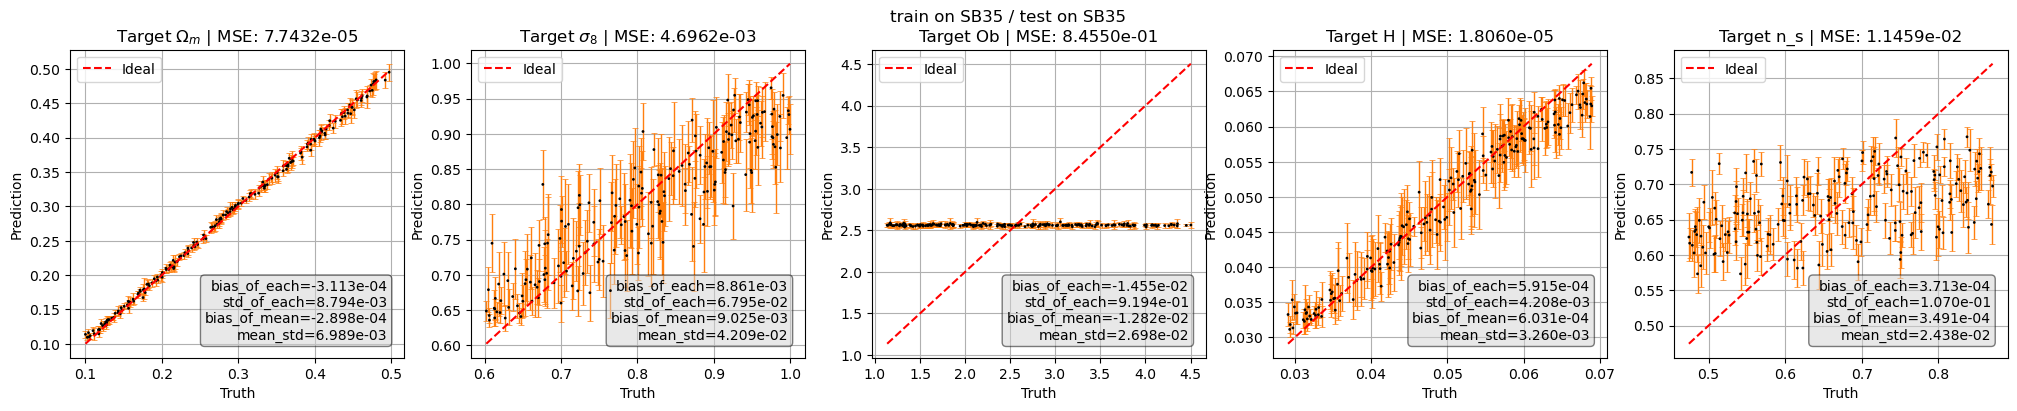

In [64]:
plot_per_simulation(data28, max_plots=6, chunk_size=15,num_samples=200, title="train on SB35 / test on SB35")
#plot_per_simulation(data35, max_plots=6, chunk_size=30,num_samples=200, title="train on SB35 / test on SB35")

## 2D

In [66]:
def plot_per_simulation(axes, data, max_plots=6, chunk_size=15, num_samples=None, sample_indices=None, title="",c='k', label="",ls="-"):
    truths, predictions, plot_dims = data

    #print(truths.shape, predictions.shape)
    array_chunk = predictions.reshape(-1,chunk_size,plot_dims)
    mean = array_chunk.mean(axis=1)
    std  = array_chunk.std(axis=1)
    true = truths[::chunk_size,:]

    diff = truths-predictions
    #ax.scatter(true[:,0],true[:,1], c="k")
    #ax.scatter(mean[:,0],mean[:,1], c="r")


    # Plot contours
    for i in range(5):
        for j in range(i):
            # Compute 2D histogram
            counts, xedges, yedges = np.histogram2d(diff[:,i], diff[:,j], bins=10)
            cs = axes[i][j].contour(xedges[:-1], yedges[:-1], counts.T,
                            levels=[20, 60, 100],
                            linewidths=[1, 2, 3],colors=c, label=label, linestyles=ls)

    #ax.scatter(diff[:,0],diff[:,1], c=c)

    #ax.scatter(true[:,0]-mean[:,0],true[:,1]-mean[:,1], c=c)
    #ax.scatter(std[:,0],std[:,1], c=c)
    return 


def make_lower_triangle_axes(n=5, figsize=(8, 8), hspace=0.05, wspace=0.05):
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(n, n, hspace=hspace, wspace=wspace)
    axes = [[None]*n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if j > i:
                continue  # skip upper triangle
            ax = fig.add_subplot(gs[i, j])
            # tidy: hide inner ticks if not on border
            if j != 0:
                ax.set_yticklabels([])
            if i != n-1:
                ax.set_xticklabels([])
            axes[i][j] = ax
    return fig, axes

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/tmp/ipykernel_1532532/3348559820.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


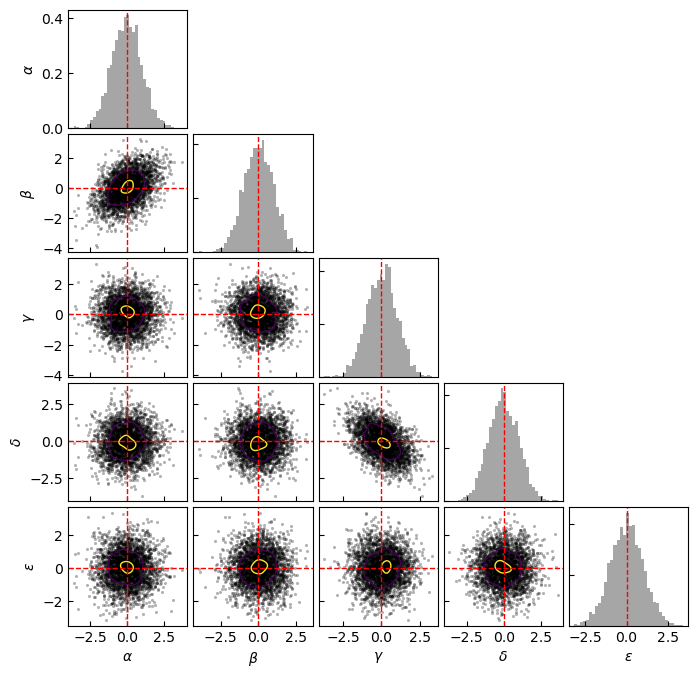

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def corner_lower_triangle(
    data,                    # shape (N, 5)
    labels=None,             # list of 5 strings
    truths=None,             # length-5 iterable of reference values (optional)
    figsize=(10, 10),
    hist_kwargs=None,        # dict passed to diagonal histograms
    scatter_kwargs=None,     # dict passed to scatter plots
    kde_levels=(0.5, 0.9),   # contour levels as fraction of max density
):
    assert data.shape[1] == 5, "Expected data with 5 columns"
    Npar = 5
    if labels is None:
        labels = [f"$\\theta_{i+1}$" for i in range(Npar)]
    if truths is None:
        truths = [None] * Npar
    hist_kwargs = {} if hist_kwargs is None else hist_kwargs
    scatter_kwargs = {} if scatter_kwargs is None else scatter_kwargs

    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(Npar, Npar, hspace=0.05, wspace=0.05)

    # Loop over rows (i) and cols (j); only plot when j <= i (lower triangle including diagonal)
    for i in range(Npar):
        for j in range(Npar):
            if j > i:
                continue  # skip upper triangle
            ax = fig.add_subplot(gs[i, j])

            if i == j:
                # marginal histogram
                ax.hist(data[:, i], bins="auto", density=True, alpha=0.7, **hist_kwargs)
                if truths[i] is not None:
                    ax.axvline(truths[i], color="red", linestyle="--", linewidth=1)
            else:
                x = data[:, j]
                y = data[:, i]
                ax.scatter(x, y, s=5, alpha=0.3, **scatter_kwargs)

                # optional KDE contour overlay
                try:
                    xy = np.vstack([x, y])
                    kde = gaussian_kde(xy)
                    # create grid to evaluate
                    xlim = ax.get_xlim()
                    ylim = ax.get_ylim()
                    xi, yi = np.mgrid[xlim[0]:xlim[1]:100j, ylim[0]:ylim[1]:100j]
                    zi = kde(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)
                    # contour levels based on fraction of max
                    levels = [zi.max() * lvl for lvl in kde_levels]
                    ax.contour(xi, yi, zi, levels=levels, linewidths=1)
                except Exception:
                    pass  # if KDE fails, ignore

            # only label the leftmost column y-axis and bottom row x-axis
            if j == 0:
                ax.set_ylabel(labels[i], fontsize=10)
            else:
                ax.set_yticklabels([])
            if i == Npar - 1:
                ax.set_xlabel(labels[j], fontsize=10)
            else:
                ax.set_xticklabels([])

            # draw truth lines on off-diagonals if provided
            if i != j:
                if truths[j] is not None:
                    ax.axvline(truths[j], color="red", linestyle="--", linewidth=1)
                if truths[i] is not None:
                    ax.axhline(truths[i], color="red", linestyle="--", linewidth=1)

    # tighten and clean up
    for ax in fig.get_axes():
        ax.tick_params(axis="both", which="both", direction="in", top=False, right=False)

    plt.tight_layout()
    return fig


# === example usage ===
if __name__ == "__main__":
    np.random.seed(1)
    # synthetic 5D correlated data
    mean = np.zeros(5)
    cov = np.eye(5)
    cov[0, 1] = cov[1, 0] = 0.4
    cov[2, 3] = cov[3, 2] = -0.5
    samples = np.random.multivariate_normal(mean, cov, size=3000)

    labels = [r"$\alpha$", r"$\beta$", r"$\gamma$", r"$\delta$", r"$\epsilon$"]
    truths = [0, 0, 0, 0, 0]

    fig = corner_lower_triangle(
        samples,
        labels=labels,
        truths=truths,
        figsize=(8, 8),
        hist_kwargs={"color": "gray"},
        scatter_kwargs={"color": "k", "linewidths": 0, "marker": "o"},
        kde_levels=(0.5, 0.9),
    )
    plt.show()


/tmp/ipykernel_1532532/3444303928.py:20: UserWarning: The following kwargs were not used by contour: 'label'
  cs = axes[i][j].contour(xedges[:-1], yedges[:-1], counts.T,


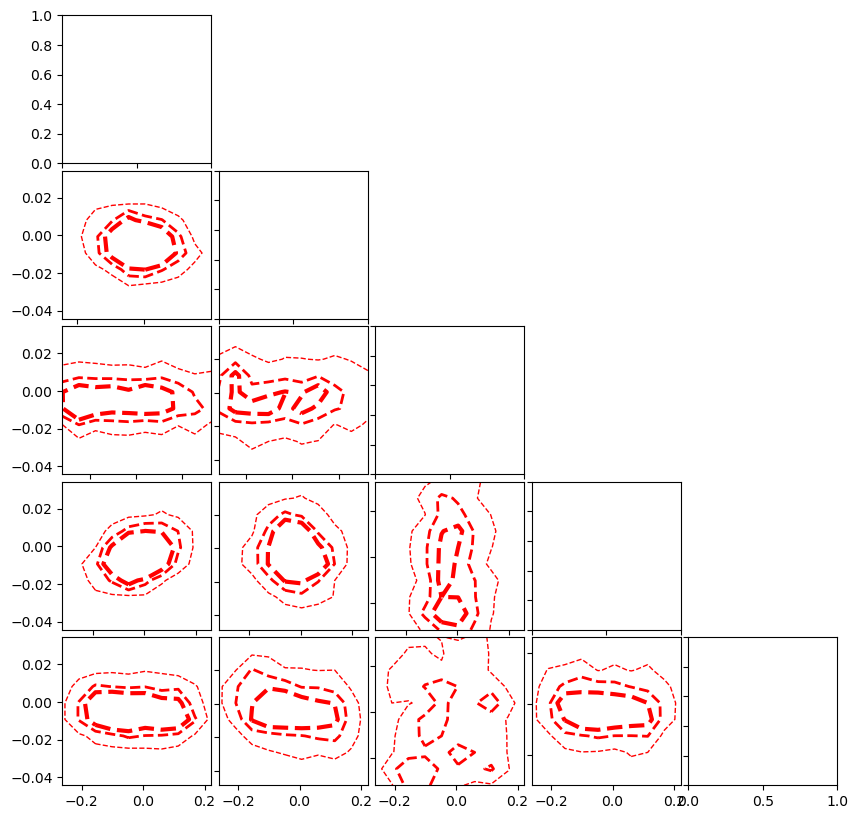

In [68]:
indices = None #range(10) #[0, 1, 2, 40]
from matplotlib.patches import Rectangle


fig, axes = make_lower_triangle_axes(n=5, figsize=(10,10), hspace=0.05, wspace=0.05)

plot_per_simulation(axes, data28, max_plots=6, chunk_size=15,num_samples=200, title="train on SB28 / test on SB28", c='r',label="SB28",ls="--")
#plot_per_simulation(axes, data35, max_plots=6, chunk_size=30,num_samples=200, title="train on SB35 / test on SB35", c='k',label="SB35")
# Create proxy artists matching contour styles
#proxy1 = Rectangle((0, 0), 1, 1, edgecolor='red', facecolor='none', linestyle='-')
#proxy2 = Rectangle((0, 0), 1, 1, edgecolor='k', facecolor='none', linestyle='-')

# Add legend with those proxies
#axs[0].legend([proxy1, proxy2], ['SB28', 'SB35'], title='')
#axs[0].set_ylabel("$\Delta \sigma_8$")
#axs[0].set_xlabel("$\Delta \Omega_m$")